<a href="https://colab.research.google.com/github/cseybold/Finance/blob/main/etherium_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [273]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
from scipy.linalg import solve_triangular
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
from scipy.special import legendre

In [274]:
etherium = yf.Ticker("ETH-USD")
ETH = etherium.history(period="max")
ETH.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,893249984,0.0,0.0
2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,885985984,0.0,0.0
2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,842300992,0.0,0.0
2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,1613479936,0.0,0.0
2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,1041889984,0.0,0.0


In [275]:
#bitcoin
bit = yf.Ticker("BTC-USD")
BTC = bit.history(period="max").loc["2017-11-09":]

In [276]:
#tech
Nvidia = yf.Ticker('NVDA')
NVDA = Nvidia.history(period='max').loc["2017-11-09":]
AMD1 = yf.Ticker('AMD')
AMD = AMD1.history(period='max').loc["2017-11-09":]

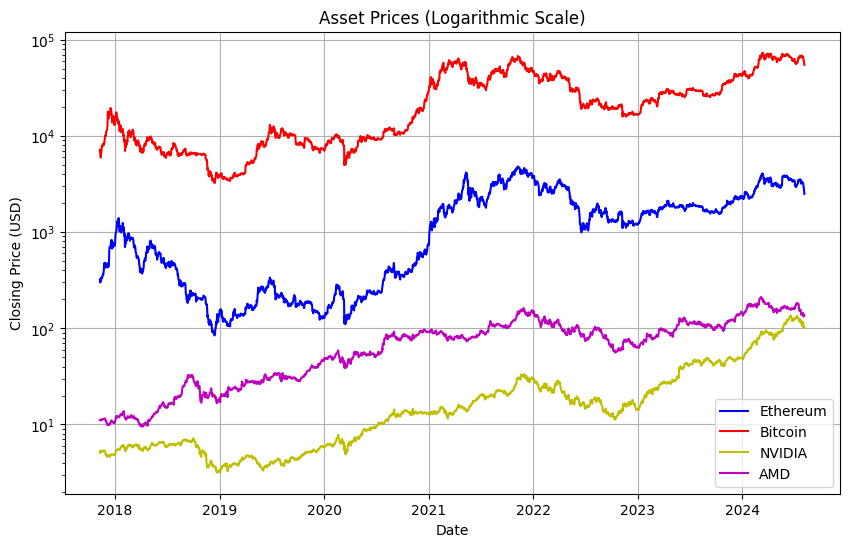

In [277]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot Ethereum data on a logarithmic y-axis
plt.semilogy(ETH.index, ETH["Close"], label="Ethereum", color="b")

plt.semilogy(BTC.index, BTC["Close"], label="Bitcoin", color="r")

plt.semilogy(NVDA.index, NVDA["Close"], label="NVIDIA", color="y")

plt.semilogy(AMD.index, AMD["Close"], label="AMD", color="m")

# Customize the plot
plt.title("Asset Prices (Logarithmic Scale)")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [278]:
na_indices_ETH = ETH[ETH['Close'].isna()].index  # Get indices of missing values
na_indices_NVDA = NVDA[NVDA['Close'].isna()].index
na_indices_AMD = AMD[AMD['Close'].isna()].index
na_indices_BTC = BTC[BTC['Close'].isna()].index

# Combine the indices
na_indices = na_indices_ETH.union(na_indices_NVDA).union(na_indices_AMD).union(na_indices_BTC)

# Drop the rows with these indices from both DataFrames
ETH_clean = ETH.drop(na_indices)
NVDA_clean = NVDA.drop(na_indices)
AMD_clean = AMD.drop(na_indices)
BTC_clean = BTC.drop(na_indices)

In [279]:
AMDcor = ETH_clean["Close"].corr(AMD_clean["Close"])
NVDAcor = ETH_clean["Close"].corr(NVDA_clean["Close"])
print(f"AMDcor is {AMDcor} and NVDAcor is {NVDAcor}")

AMDcor is nan and NVDAcor is nan


In [280]:
assets = [BTC, ETH, NVDA, AMD]
for asset in assets:
  del asset["Dividends"]
  del asset["Stock Splits"]


In [281]:
def least_squares(A, y):
  """
  Solves the least squares problem using QR decomposition.

  Args:
      A: Design matrix (2D numpy array).
      y: Response vector (1D numpy array).

  Returns:
      Coefficients of the fitted model (1D numpy array).
  """
  m, n = A.shape  # Get dimensions of A

  # QR decomposition of A
  Q, R = np.linalg.qr(A, mode='reduced')

  # Check for rank deficiency (optional)
  rtol = 1e-5  # Tolerance for near-zero diagonal elements
  rank = np.linalg.norm(np.diag(R), ord=np.inf)
  if rank < n - rtol:
    print("Warning: Rank deficiency detected. Least squares solution might be unreliable.")

  # Solve the reduced system using back substitution
  z = Q.T @ y
  c = solve_triangular(R, z, lower=False)  # Upper triangular solve

  return c


ETH_data = ETH["Close"]
x = np.arange(len(ETH_data))
y = ETH_data.to_numpy()
pDi = 15

# Create design matrix A using PolynomialFeatures
poly = PolynomialFeatures(degree=pDi, include_bias=True)  # Include bias term (constant)
x_poly = poly.fit_transform(x.reshape(-1, 1))  # Reshape for 2D compatibility
c = least_squares(x_poly, y)



# Prediction
xStar = np.arange(len(x))
yStar = np.zeros(len(xStar))
for j in range(pDi + 1):
  yStar += c[j] * poly.transform(xStar.reshape(-1, 1))[:, j]  # Use transformed features

# Calculate normalized errors
normY = np.linalg.norm(y) / np.sqrt(len(y))
lsResidual = np.linalg.norm(y - x_poly @ c) / (normY * np.sqrt(len(y)))
RMSAcy = lsResidual
print("RMSAcy:", RMSAcy)

RMSAcy: 0.15717978317292022


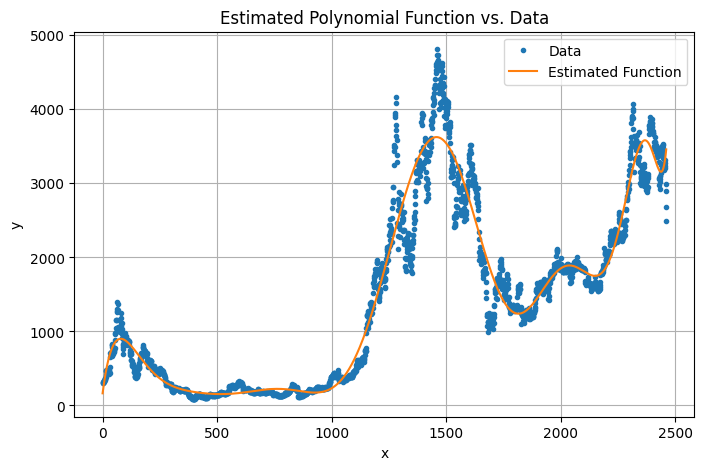

In [282]:
plt.figure(figsize=(8, 5))  # Set plot size

# Plot the original data points
plt.plot(x, y, '.', label='Data')

# Plot the estimated function (yStar)
plt.plot(xStar, yStar, '-', label='Estimated Function')

# Customize plot elements
plt.xlabel('x')
plt.ylabel('y')
plt.title('Estimated Polynomial Function vs. Data')
plt.legend()
plt.grid(True)

plt.show()  # Display the plot

In [283]:
#make function to recognize when short term bounces arent captured by derivative

def compute_derivative(poly,x):
    deriv_poly = [poly[i] * i * x**(i-1) for i in range(1, len(poly))]
    prime = np.sum(deriv_poly)
    return prime

derivative_values = [compute_derivative(c, xi) for xi in x]

# Add the derivative values to the dataframe
ETH["Derivative"] = derivative_values

# Display the first few rows of the updated dataframe
ETH.head()

,Open,High,Low,Close,Volume,Derivative
Date,,,,,,
2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,893249984,24.016536
2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,885985984,23.472149
2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,842300992,22.936209
2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,1613479936,22.408604
2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,1041889984,21.889227


In [284]:
ETH["Tommorow"] = ETH["Close"].shift(-1)
ETH["DayTarget"] = (ETH["Tommorow"] > ETH["Close"]).astype(int)
ETH["NextWeek"] = ETH["Close"].shift(-5)
ETH["WeekTarget"] = (ETH["NextWeek"] > ETH["Close"]).astype(int)

In [285]:
from sklearn.ensemble import RandomForestClassifier

modelDay = RandomForestClassifier(n_estimators=300, min_samples_split=60, random_state = 1)
modelWeek = RandomForestClassifier(n_estimators=300, min_samples_split=60, random_state = 1)

train = ETH.iloc[:-100]
test = ETH.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low", "Derivative"]
modelDay.fit(train[predictors], train["DayTarget"])
modelWeek.fit(train[predictors], train["WeekTarget"])

RandomForestClassifier(min_samples_split=60, n_estimators=300, random_state=1)

In [286]:
#bad, much better at bottom

from sklearn.metrics import precision_score
predsDay = modelDay.predict(test[predictors])
predsWeek = modelWeek.predict(test[predictors])

print(precision_score(test["DayTarget"], predsDay))
print(precision_score(test["WeekTarget"], predsWeek))

0.45454545454545453
0.49230769230769234


<Axes: xlabel='Date'>

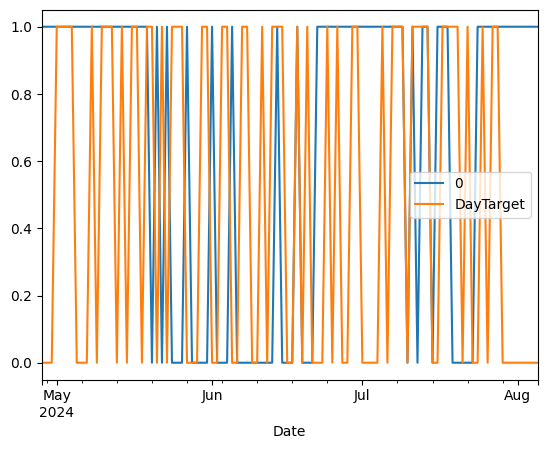

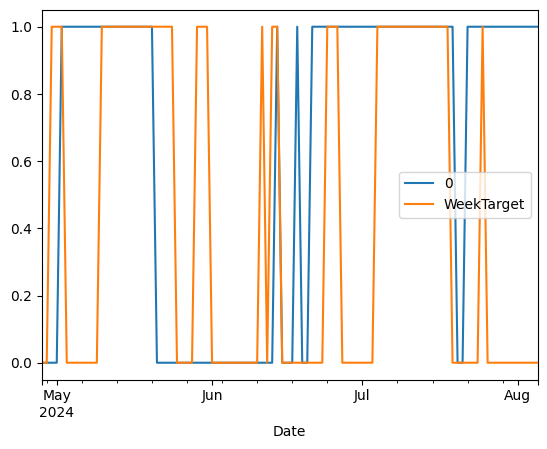

In [287]:
predsDay = pd.Series(predsDay, index=test.index)
predsWeek = pd.Series(predsWeek, index=test.index)
combinedDay = pd.concat([predsDay, test["DayTarget"]], axis=1)
combinedDay.plot()
combinedWeek = pd.concat([predsWeek, test["WeekTarget"]], axis=1)
combinedWeek.plot()


In [288]:
def predictDay(train, test, predictors, model):
    model.fit(train[predictors], train["DayTarget"])
    preds = model.predict(test[predictors])
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="DayPredictions")
    combined = pd.concat([test["DayTarget"], preds], axis=1)
    return combined

def predictWeek(train, test, predictors, model):
    model.fit(train[predictors], train["WeekTarget"])
    preds = model.predict(test[predictors])
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="WeekPredictions")
    combined = pd.concat([test["WeekTarget"], preds], axis=1)
    return combined

def backtestDay(data, model, predictors, start=1000, step=200):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predictDay(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

def backtestWeek(data, model, predictors, start=1000, step=200):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predictWeek(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [289]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = ETH.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    ETH[ratio_column] = ETH["Close"] / rolling_averages["Close"]

    trend_columnDay = f"DayTrend_{horizon}"
    ETH[trend_columnDay] = ETH.shift(1).rolling(horizon).sum()["DayTarget"]

    trend_columnWeek = f"WeekTrend_{horizon}"
    ETH[trend_columnWeek] = ETH.shift(1).rolling(horizon).sum()["WeekTarget"]

    new_predictors += [ratio_column, trend_columnDay, trend_columnWeek]

ETH = ETH.dropna()

In [290]:
model = RandomForestClassifier(n_estimators=500, min_samples_split=50, random_state=2012)
predictionsDay = backtestDay(ETH, model, new_predictors)
predictionsWeek = backtestWeek(ETH, model, new_predictors)

predictionsDay["DayPredictions"].value_counts()
predictionsWeek["WeekPredictions"].value_counts()

print(precision_score(predictionsDay["DayTarget"], predictionsDay["DayPredictions"]))
print(precision_score(predictionsWeek["WeekTarget"], predictionsWeek["WeekPredictions"]))

0.6719367588932806
0.7633587786259542


In [271]:
#higher min_child_weight = better week accuracy but worse day accuracy
import xgboost as xgb

model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    min_child_weight=60,
    subsample=0.75,
    reg_alpha=0.01,
    reg_lambda=1,
    random_state=2012
)
predictionsDay = backtestDay(ETH, model, new_predictors)
predictionsWeek = backtestWeek(ETH, model, new_predictors)

predictionsDay["DayPredictions"].value_counts()
predictionsWeek["WeekPredictions"].value_counts()

print(precision_score(predictionsDay["DayTarget"], predictionsDay["DayPredictions"]))
print(precision_score(predictionsWeek["WeekTarget"], predictionsWeek["WeekPredictions"]))

#too good... next time check for data leakage, especially with the polynomial slopes and specifically for weeklong predictions

0.6497890295358649
0.8008474576271186


In [291]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'reg_alpha': [0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 10]
}

# Initialize the XGBoost model
model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    min_child_weight=50,
    subsample=0.75,
    random_state=2012
)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

predictionsDay = backtestDay(ETH, grid_search, new_predictors)

predictionsDay["DayPredictions"].value_counts()

print(precision_score(predictionsDay["DayTarget"], predictionsDay["DayPredictions"]))

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best reg_alpha: {best_params['reg_alpha']}")
print(f"Best reg_lambda: {best_params['reg_lambda']}")

0.6626016260162602
Best reg_alpha: 1
Best reg_lambda: 10
